# Modeling

In [1]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer


In [3]:
import fuzzywuzzy

ModuleNotFoundError: No module named 'fuzzywuzzy'

## Feature engineering for time variables

Now that we have our time variables as we wanted and the trip counts for each one of those time periods, we need to make sure that our cyclical variables, namely dayofyear, weekday and hour, will preserve the cyclical characteristics of months, days and weeks, this is to say that the first day of the week is close to the last day of the following week. [LINK](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

This transformation is explained in the following picture:

![alt text](http://blog.davidkaleko.com/images/unit_circle.png)


In [0]:
# Transform the three time variables into cyclical variables using sine and cosine

counts_union['dayofyear_sin'] = np.sin(counts_union.dayofyear*(2.*np.pi/365))
counts_union['dayofyear_cos'] = np.cos(counts_union.dayofyear*(2.*np.pi/365))
counts_union['weekday_sin'] = np.sin(counts_union.weekday*(2.*np.pi/7))
counts_union['weekday_cos'] = np.cos(counts_union.weekday*(2.*np.pi/7))
counts_union['hour_sin'] = np.sin(counts_union.hour*(2.*np.pi/24))
counts_union['hour_cos'] = np.cos(counts_union.hour*(2.*np.pi/24))

#Preview
counts_union.head()

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest,rate_of_change,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,0,6,0,0.0,2.0,-2.0,0.0,1.0,-0.781831,0.62349,0.000000,1.000000
1,0,6,1,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.258819,0.965926
2,0,6,2,2.0,0.0,2.0,0.0,1.0,-0.781831,0.62349,0.500000,0.866025
3,0,6,3,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.707107,0.707107
4,0,6,4,0.0,1.0,-1.0,0.0,1.0,-0.781831,0.62349,0.866025,0.500000


Here we can evidence that by virtue of sines and cosines, hours will be arranged in a cyclical manner so the model can obtain this information in order to process data correctly.

## Modeling using Random Forest

Now let's use our previous dataset `counts_union` to model the rate of change in Union Station using a non-linear regression model, for this case and as a first approach we will be using Random Forest to model the regression, however, further modeling iterations must be carried out.

In [0]:
#Sneak peak
counts_union.head(2)

,dayofyear,weekday,hour,count_trips_orig,count_trips_dest,rate_of_change,dayofyear_sin,dayofyear_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,0,6,0,0.0,2.0,-2.0,0.0,1.0,-0.781831,0.62349,0.000000,1.000000
1,0,6,1,1.0,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.258819,0.965926


Now let's subset our dataset for modeling by including only the variables we need. For this case our model will be only time-dependent as since it's modeled as a cyclical process, we expect that this data could account for seasonal variables such as the temperature and precipitation.

Nevertheless, future stages of development could include other predictors such as ``is_holiday``, `mean_temperature`, `humidity`, `mean_windspeed`, `casual_rides`, `member_rides`, ``is_event_date``, among many others.

In [0]:
# Set the variables
X = counts_union[['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos','hour_sin', 'hour_cos']]
y= counts_union[['rate_of_change']]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Now we will use ``GridSearchCV`` for evaluating a combination of hyperparameters that were previously explored. This GridSearch is already focused on a specific area of the hyperspace of parameters that was detected manually by exploring the training and cross validation $R^{2}$ one by one. These sets of parameters given should provide one optimal model derived from this data. 

In [0]:
#Create pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('rf', RandomForestRegressor(random_state=100, max_features=4))])

#Create params grid
params_list = [{'rf__n_estimators': np.linspace(30, 70, 5, endpoint=True, dtype=int),
                'rf__max_depth' : np.linspace(1, 10, 5, endpoint=True, dtype=int),
                'rf__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'rf__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
               }]

# Perform grid search
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params_list, 
                           cv=5, 
                           scoring='r2',
                          verbose=2,
                          n_jobs=-1,
                          return_train_score=True)
  
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2497 out of 2500 | elapsed:  5.2min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=4,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                          

First let's get the subset of optimal parameters obtained by the ``GridSearchCV`` algorithm and its score.

In [0]:
#Get best params
grid_search.best_params_

{'rf__max_depth': 10,
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 0.0001,
 'rf__n_estimators': 70}

In [0]:
#Get best score
grid_search.best_score_.round(2)

0.69

For this case we have chosen $R^{2}$ as the metric for model selection (as seen before). Hence, we will evaluate the results obtained with this metric for both training and test set.

In [0]:
#Use the best model for prediction on training set and get metric
r2_score(y_train, grid_search.predict(X_train)).round(2)

0.77

In [0]:
#Use the best model for prediction on test set and get metric
r2_score(y_test, grid_search.predict(X_test)).round(2)

0.7

In [0]:
# Feature importance for time series data
pd.DataFrame(data=grid_search.best_estimator_.named_steps['rf'].feature_importances_,
            index=X_train.columns)

,0
dayofyear_sin,0.241934
dayofyear_cos,0.077818
weekday_sin,0.136558
weekday_cos,0.011994
hour_sin,0.299072
hour_cos,0.232625


After reviewing the results, we can evidence that indeed modeling rate of change dependent of time as a cyclic variable helps us predict with certain accuracy its behavior.

Nevertheless, we must consider de following for **future work**

* Even with the data at hand, the model could be improved applying a more rigorous hyperparameter optimization, which is key in stochastic algorithms. Or another alternative could be to model the demand as time series using models such as ARIMA or SARIMA and compare its performance.

* To improve model metrics, we could also think of adding data from previous and following years to the model, specifically to provide more yearly seasonality information to the model, this might reduce variance.

* The model is in early stages of development, to reduce model variance (overfitting) there are some solutions to be tested: restrict complexity using hyperparameters (although this was carried out) and get more data to improve generalization capability.

* Using the real-time station status data available through the API, one could instantly assess model performance using real data.


### Evaluating predictions for months of high demand

We will compare the predictions for June, July and August into a timeline with the real data to review overall model performance.

In [0]:
#Set the time range
init_day = 152  #Jun 1st
final_day = 243  #Aug 31st

#Real data
real_y = y.rate_of_change[(counts_union.dayofyear >= init_day) & 
                       (counts_union.dayofyear <= final_day)]

#Calculate predictions
X_subset = X[(counts_union.dayofyear >= init_day) & 
                       (counts_union.dayofyear <= final_day)]

predic_y = grid_search.predict(X_subset)

<function matplotlib.pyplot.show>

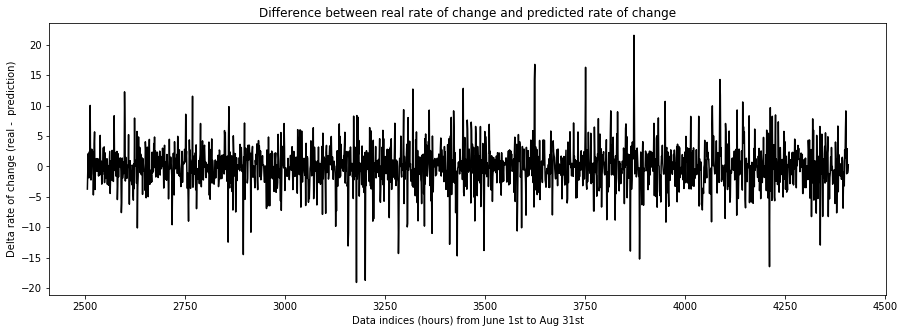

In [0]:
#Get the indices of the data points
x_values = counts_union.index[(counts_union.dayofyear >= init_day) & (counts_union.dayofyear <= final_day)]

#Plot
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(15,5))

#Plot difference between real and predicted value
plt.plot(x_values, real_y- predic_y, c='black')
plt.xlabel('Data indices (hours) from June 1st to Aug 31st')
plt.ylabel('Delta rate of change (real -  prediction)')
plt.title('Difference between real rate of change and predicted rate of change')
plt.show

### Final remarks

* The most important factor for prediction is the hour of the day, both on the cosine and sine components. The dayofyear and weekday also have some influence, mainly on their sine component, since these are the variables that provide information about weekly and yearly seasonality.

* In terms of prediction for months of high demand, the model seems to do a good job on most days, in which the difference between the real value and prediction are close to zero and between the $[-5,5]$ range, with a capacity of 26 bikes, this error might be acceptable (depending on the hour of the day). However, several peak points in the difference are still present, it's important identify explanatory variables for those peaks in order to improve model performance.

* This model could be used for predicting the performance of other stations aswell since the data is already clean and prepared for the analysis.
